In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/extratrees/scikitlearn/default/1/extra_model.pkl
/kaggle/input/bagging/scikitlearn/default/1/bag_model.pkl
/kaggle/input/ember-adversarial-samples/adversarial_train_data.csv
/kaggle/input/ember-2018-v2-features/test_ember_2018_v2_features.parquet
/kaggle/input/ember-2018-v2-features/train_ember_2018_v2_features.parquet
/kaggle/input/gradientboosting/scikitlearn/default/1/gdb_model.pkl
/kaggle/input/adaboost/scikitlearn/default/1/ada_model.pkl


In [2]:
!pip install lightgbm adversarial-robustness-toolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.3 MB/s eta 0:00:0000:01


In [3]:
# 1. Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier,GradientBoostingClassifier,RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from art.estimators.classification import SklearnClassifier, XGBoostClassifier
from art.attacks.evasion import ZooAttack

from scipy.stats import randint, uniform
from joblib import parallel_backend

import gc
import joblib

import warnings
warnings.filterwarnings("ignore")

# 🔧 Set global style
sns.set_style("whitegrid")

# 1. Data Processing

In [4]:
# Load Data
df_train = pd.read_parquet('/kaggle/input/ember-2018-v2-features/train_ember_2018_v2_features.parquet')
df_test = pd.read_parquet('/kaggle/input/ember-2018-v2-features/test_ember_2018_v2_features.parquet')

# Filter labeled data and downcast to reduce memory usage
df_train = df_train[df_train['Label'].isin([0, 1])]
df_train = df_train.sample(frac=0.3, random_state=42).reset_index(drop=True)  # use 30% of labeled data
for df in [df_train, df_test]:
    for col in df.columns:
        if df[col].dtype == 'float64':
            df[col] = df[col].astype('float32')
        elif df[col].dtype == 'int64':
            df[col] = df[col].astype('int32')

In [5]:
df_train.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F2373,F2374,F2375,F2376,F2377,F2378,F2379,F2380,F2381,Label
0,0.132428,0.015700,0.008972,0.005976,0.009037,0.005550,0.003313,0.003115,0.009533,0.002488,...,673904.0,0.0,0.0,2180.0,585728.0,0.0,0.0,0.0,0.0,0.0
1,0.011955,0.000504,0.000125,0.000099,0.000196,0.000296,0.000168,0.000191,0.000100,0.000052,...,0.0,0.0,0.0,1336.0,65536.0,0.0,0.0,0.0,0.0,0.0
2,0.194660,0.011007,0.006595,0.005661,0.010983,0.005284,0.004486,0.003485,0.011665,0.003046,...,0.0,0.0,0.0,872.0,278528.0,0.0,0.0,0.0,0.0,0.0
3,0.177488,0.027633,0.009717,0.005789,0.010365,0.003945,0.003595,0.002136,0.008532,0.002025,...,9720.0,0.0,0.0,568.0,8192.0,0.0,0.0,0.0,0.0,0.0
4,0.253580,0.011862,0.001344,0.001812,0.002196,0.001089,0.002441,0.000866,0.000971,0.001075,...,0.0,0.0,0.0,8.0,8192.0,0.0,0.0,72.0,8200.0,0.0


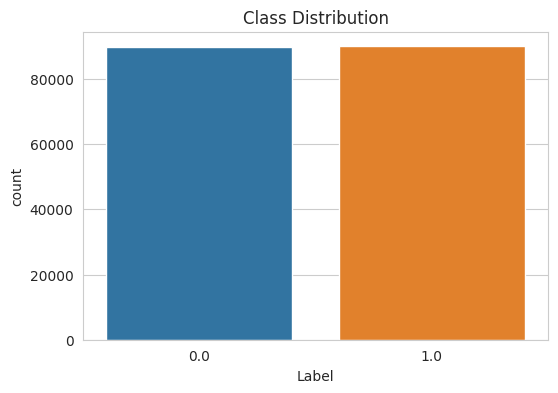

In [6]:
# EDA: Class Distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df_train, x='Label')
plt.title('Class Distribution')
plt.show()

In [7]:
# Prepare train/val/test splits
X = df_train.drop(columns='Label')
y = df_train['Label']
X_test = df_test.drop(columns='Label')
y_test = df_test['Label']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

del df_train, df_test
gc.collect()

2230

In [8]:
# Step 1: Variance Threshold
vt = VarianceThreshold(threshold=0.01)
X_train_vt = vt.fit_transform(X_train)
X_val_vt = vt.transform(X_val)
X_test_vt = vt.transform(X_test)

In [9]:
# Step 2: SelectKBest using ANOVA F-score
selector = SelectKBest(score_func=f_classif, k=800)
X_train_fs = selector.fit_transform(X_train_vt, y_train)
X_val_fs = selector.transform(X_val_vt)
X_test_fs = selector.transform(X_test_vt)

In [10]:
# Optional: Tree-Based Importance Filtering
rf_temp = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
rf_temp.fit(X_train_fs, y_train)
importances = rf_temp.feature_importances_
top_idx = np.argsort(importances)[-500:]  # keep top 500

X_train_final = X_train_fs[:, top_idx]
X_val_final = X_val_fs[:, top_idx]
X_test_final = X_test_fs[:, top_idx]

In [11]:
count_0_1 = y_train.value_counts()
print(count_0_1)

Label
1.0    72012
0.0    71968
Name: count, dtype: int64


In [16]:
count_0 = y_test.value_counts()
print(count_0)

Label
0.0    99985
1.0    99971
Name: count, dtype: int64


In [17]:
count_1=y_val.value_counts()
count_1

Label
1.0    18004
0.0    17992
Name: count, dtype: int64

# 2. Utility Functions

## 2.1. Results

In [12]:
def get_results(models,xtest,y_test):
  results = []
  for model_name, model in models.items():
      y_pred_proba = model.predict_proba(xtest)[:, 1]
      y_pred = (y_pred_proba >= 0.5).astype(int)  # Threshold at 0.5
      
      # Calculate metrics
      accuracy = accuracy_score(y_test, y_pred)
      roc_auc = roc_auc_score(y_test, y_pred_proba)
      precision = precision_score(y_test, y_pred)
      recall = recall_score(y_test, y_pred)
      f1 = f1_score(y_test, y_pred)

      results.append({
          'Model': model_name,
          'Accuracy': accuracy,
          'ROC AUC': roc_auc,
          'Precision': precision,
          'Recall': recall,
          'F1 Score': f1
      })

      print(f"{model_name} Performance:")
      print("Accuracy:", round(accuracy, 4))
      print("ROC AUC:", round(roc_auc, 4))
      print("Precision:", round(precision, 4))
      print("Recall:", round(recall, 4))
      print("F1 Score:", round(f1, 4))
      print()

  # Convert results to DataFrame
  results_df = pd.DataFrame(results).set_index('Model')
  return results_df

In [13]:
def plot_results(results_df):
  # Plotting
  results_df.plot(kind='bar', figsize=(12, 6), rot=45)
  plt.title("Model Comparison")
  plt.ylabel("Score")
  plt.ylim(0.3, 1.0)
  plt.legend(loc='lower right')
  plt.tight_layout()
  plt.show()

  fig, axes = plt.subplots(2, 3, figsize=(18, 10))
  metrics = ['Accuracy', 'ROC AUC', 'Precision', 'Recall', 'F1 Score']
  for i, metric in enumerate(metrics):
      results_df[[metric]].plot(kind='bar', ax=axes[i//3, i%3], title=metric, legend=False)
  plt.tight_layout()
  plt.show()


In [14]:
def roc_auc_plot(models,xtest,y_test):
  plt.figure(figsize=(8,6))
  for model_name, model in models.items():
      y_score = model.predict_proba(xtest)[:, 1]
      fpr, tpr, _ = roc_curve(y_test, y_score)
      roc_auc = auc(fpr, tpr)
      plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc="lower right")
  plt.show()

In [15]:
def plot_confusion_matrix(models,xtest,y_test):
  # Define figure with subplots (adjust grid size based on number of models)
  fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
  axes = axes.flatten()  # Flatten to easily index

  # Loop over each model and plot
  for ax, (model_name, model) in zip(axes, models.items()):
      y_pred = model.predict(xtest)
      cm = confusion_matrix(y_test, y_pred)
      disp = ConfusionMatrixDisplay(confusion_matrix=cm)
      disp.plot(ax=ax, colorbar=False)
      ax.set_title(model_name)

  # Hide any unused subplots if number of models < total subplots
  for ax in axes[len(models):]:
      ax.axis('off')

  plt.tight_layout()
  plt.show()

## 2.2. Create and apply Zeroth Order Optimization Attack with ART

In [16]:
def zoo_attack(model_name,model,x_train):
    art_classifier = SklearnClassifier(model=model)
    zoo = ZooAttack(classifier=art_classifier, confidence=0.0, targeted=False, learning_rate=1e-2, max_iter=10,
    binary_search_steps=10, initial_const=1e-3, abort_early=True, use_resize=False, 
    use_importance=False, nb_parallel=4, batch_size=1, variable_h=0.1)
    print(len(x_train))
    x_train_adv = zoo.generate(x_train)
    return x_train_adv

## 2.3. Evaluate Model on benign and adversarial samples

In [ ]:
# def evaluate_model(model_name,model,x_train_adv,ytrain):  
#     score = model.score(X_train_final, y_train)
#     print("Benign Training Score: %.4f" % score)
#     score = model.score(x_train_adv, ytrain)
#     print("Adversarial Training Score: %.4f" % score)

# 3. Models

In [17]:
models_path='/kaggle/input/adaboost/scikitlearn/default/1'
ada_model=None
bag_model=None
gdb_model = None
extra_model=None
if os.path.exists(models_path):
    print(True)
    bag_model=joblib.load("/kaggle/input/bagging/scikitlearn/default/1/bag_model.pkl")
    ada_model=joblib.load('/kaggle/input/adaboost/scikitlearn/default/1/ada_model.pkl')
    gdb_model=joblib.load('/kaggle/input/extratrees/scikitlearn/default/1/extra_model.pkl')
    extra_model=joblib.load('/kaggle/input/gradientboosting/scikitlearn/default/1/gdb_model.pkl')

True


## 3.1. AdaBoost Classifier

In [ ]:
ada_model = AdaBoostClassifier(n_estimators=50, learning_rate=0.1, algorithm='SAMME.R', random_state=None)
ada_model.fit(X=X_train_final, y=y_train)

## 3.2. Bagging Classifier

In [ ]:
bag_model = BaggingClassifier(base_estimator=None, n_estimators=10, max_samples=1.0, max_features=1.0, 
                          bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, 
                          n_jobs=None, random_state=None, verbose=0)
bag_model.fit(X=X_train_final, y=y_train)

## 3.3. ExtraTrees Classifiers

In [ ]:
extra_model = ExtraTreesClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2, 
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
                             max_leaf_nodes=None, min_impurity_decrease=0.0,bootstrap=False, oob_score=False, n_jobs=None, random_state=None, verbose=0, 
                             warm_start=False, class_weight=None)  
extra_model.fit(X=X_train_final, y=y_train)

## 3.4. Gradient Boosting Classifier

In [ ]:
gdb_model = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, 
                                   criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, 
                                   min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, 
                                   init=None, random_state=None, max_features=None, 
                                   verbose=0, max_leaf_nodes=None, warm_start=False,
                                   validation_fraction=0.1, n_iter_no_change=None, tol=0.0001)
gdb_model.fit(X=X_train_final, y=y_train)

## 3.5 Save Models

In [18]:
models = {
    "Ada Boost": ada_model,
    "Bagging Classifier": bag_model,
    "Gradient Boosting": gdb_model,
    #"XGBoostClassifier": xgb_model,
    "Extra Trees Classifier": extra_model
}

In [ ]:
import joblib
joblib.dump(ada_model, '/kaggle/working/ada_model.pkl')
joblib.dump(bag_model, '/kaggle/working/bag_model.pkl')
joblib.dump(gdb_model, '/kaggle/working/gdb_model.pkl')
joblib.dump(extra_model, '/kaggle/working/extra_model.pkl')

# 4. Benign Model Performance Evaluation

Ada Boost Performance:
Accuracy: 0.722
ROC AUC: 0.8281
Precision: 0.6664
Recall: 0.8891
F1 Score: 0.7618

Bagging Classifier Performance:
Accuracy: 0.9374
ROC AUC: 0.9823
Precision: 0.9222
Recall: 0.9554
F1 Score: 0.9385

Gradient Boosting Performance:
Accuracy: 0.9364
ROC AUC: 0.9815
Precision: 0.9272
Recall: 0.9471
F1 Score: 0.9371

Extra Trees Classifier Performance:
Accuracy: 0.8609
ROC AUC: 0.9481
Precision: 0.816
Recall: 0.9319
F1 Score: 0.8701



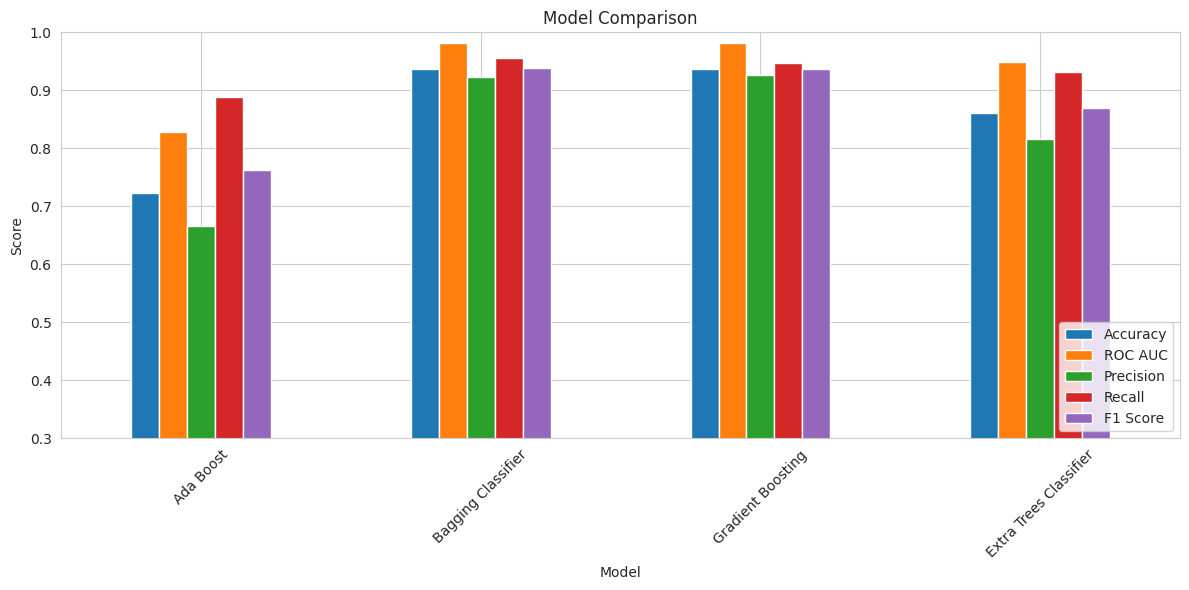

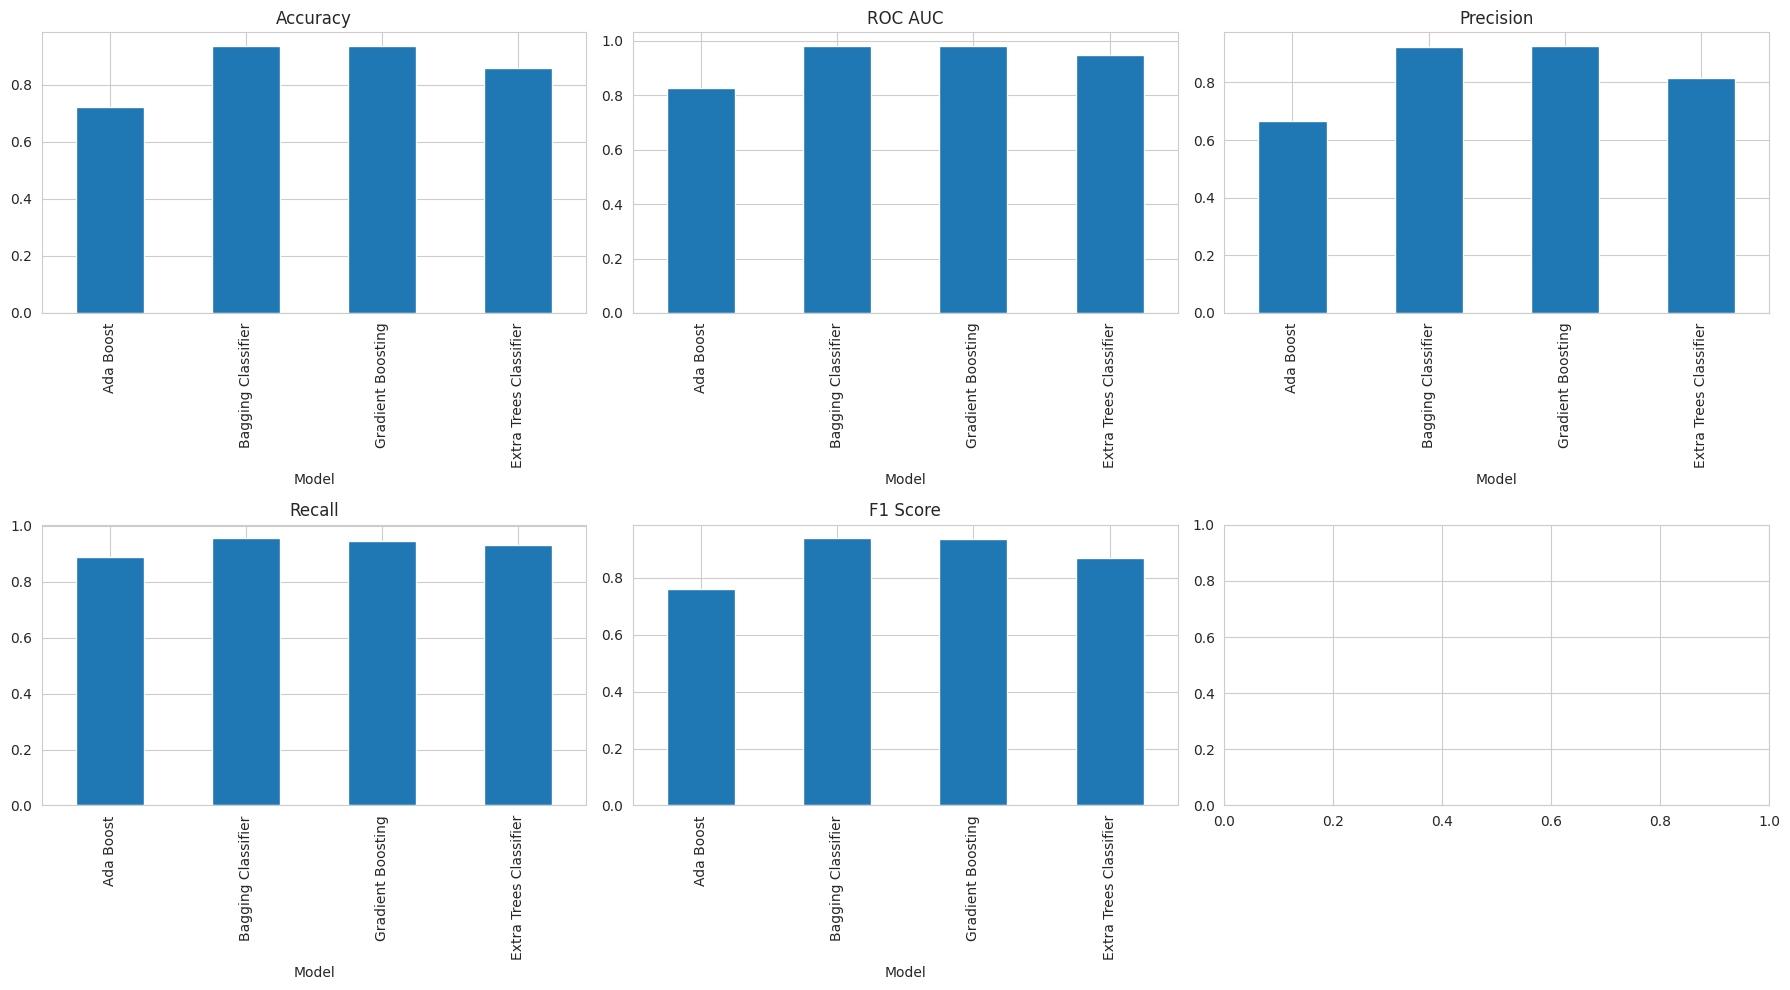

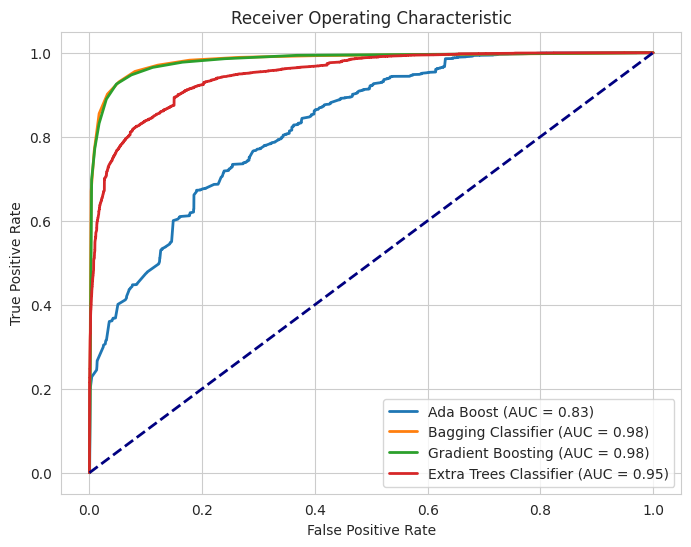

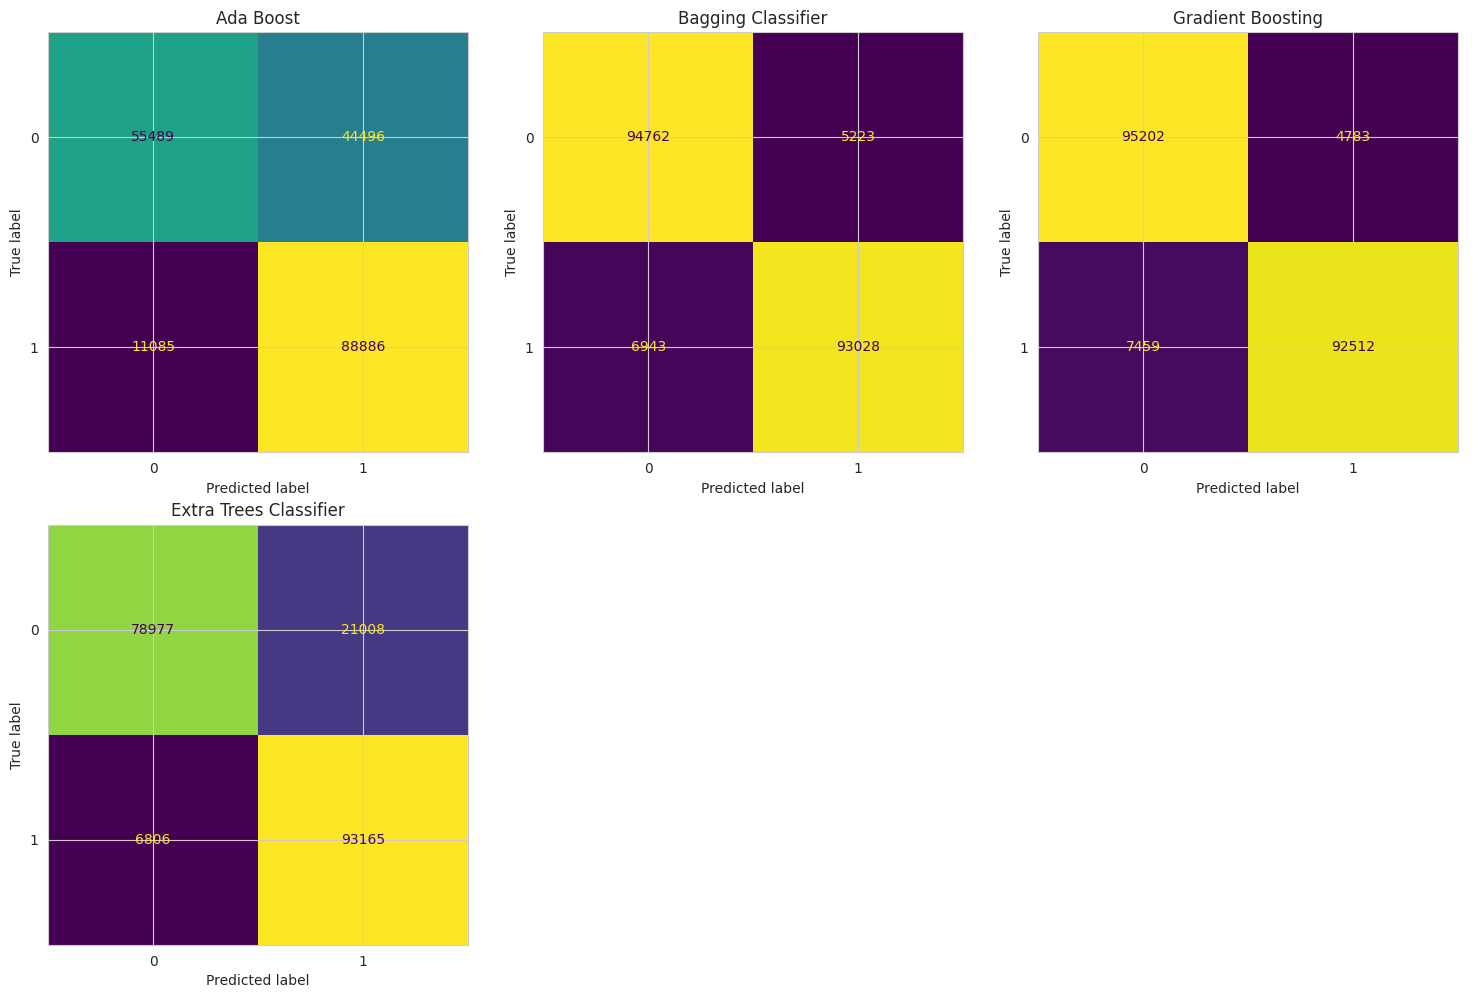

In [19]:
plot_results(get_results(models,X_test_final,y_test))
roc_auc_plot(models,X_test_final,y_test)
plot_confusion_matrix(models,X_test_final,y_test)

In [ ]:
batch_size = 14398
current_index = 0
adv_ex = [np.empty((0, 500)), np.empty(0)]

for model_name, model in models.items():
    x_train_batch = X_train_final[current_index:current_index + batch_size]
    y_train_batch = y_train[current_index:current_index + batch_size]
    x_train_adv= zoo_attack(model_name,model,x_train_batch)
    print(len(x_train_adv))
    # evaluate_model(model_name,model,x_train_adv,y_train_batch)
    
    X_train_final=np.vstack((X_train_final,x_train_adv))
    y_train=np.hstack((y_train,y_train_batch))
    adv_ex[0]=np.vstack((adv_ex[0],x_train_adv))
    adv_ex[1]=np.hstack((adv_ex[1],y_train_batch))
    
    shuffler = np.random.permutation(len(X_train_final))
    X_train_final = X_train_final[shuffler]
    y_train = y_train[shuffler]
    
    current_index += batch_size

In [ ]:
# Assuming x_train and y_train are numpy arrays or pandas DataFrames
# Convert x_train to DataFrame
x_train_df = pd.DataFrame(X_train_final)

# Convert y_train to DataFrame (make sure it matches the dimensions, usually (n_samples, 1))
y_train_df = pd.DataFrame(y_train)

# Concatenate x_train and y_train along axis 1 (columns)
combined_df = pd.concat([x_train_df, y_train_df], axis=1)

# Save the combined DataFrame to a CSV file
combined_df.to_csv('adversarial_train_data.csv', index=False)

Models performance on Adversarial examples: 

Ada Boost Performance:
Accuracy: 0.7916
ROC AUC: 0.8674
Precision: 0.744
Recall: 0.8886
F1 Score: 0.8099

Bagging Classifier Performance:
Accuracy: 0.9976
ROC AUC: 1.0
Precision: 0.997
Recall: 0.9982
F1 Score: 0.9976

Gradient Boosting Performance:
Accuracy: 0.9999
ROC AUC: 1.0
Precision: 1.0
Recall: 0.9998
F1 Score: 0.9999

Extra Trees Classifier Performance:
Accuracy: 0.8943
ROC AUC: 0.9638
Precision: 0.873
Recall: 0.9227
F1 Score: 0.8972



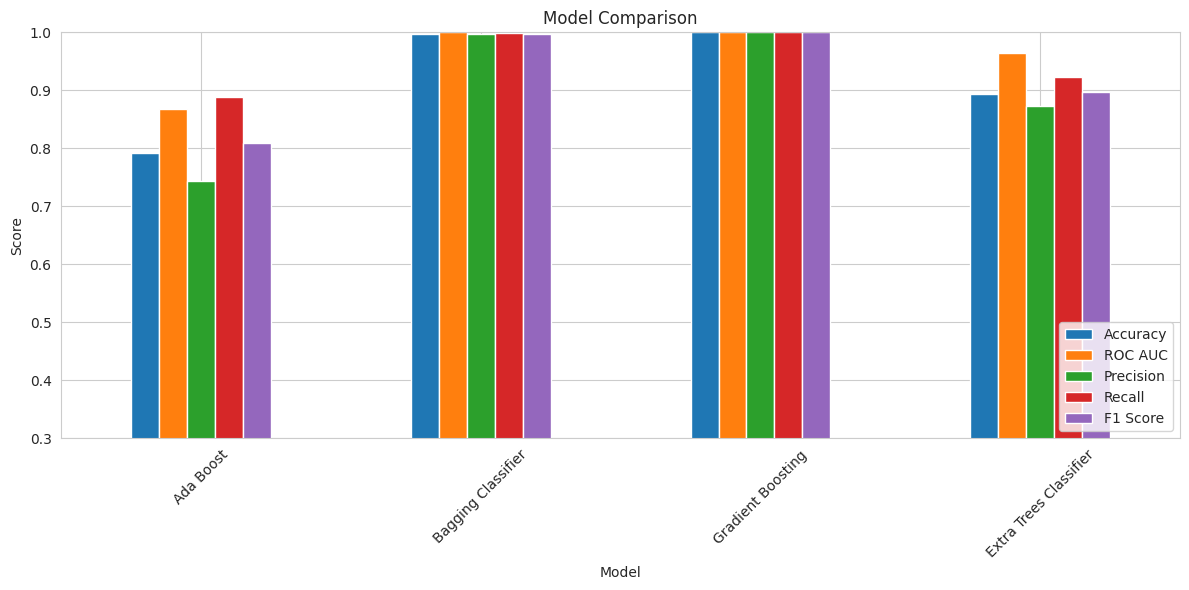

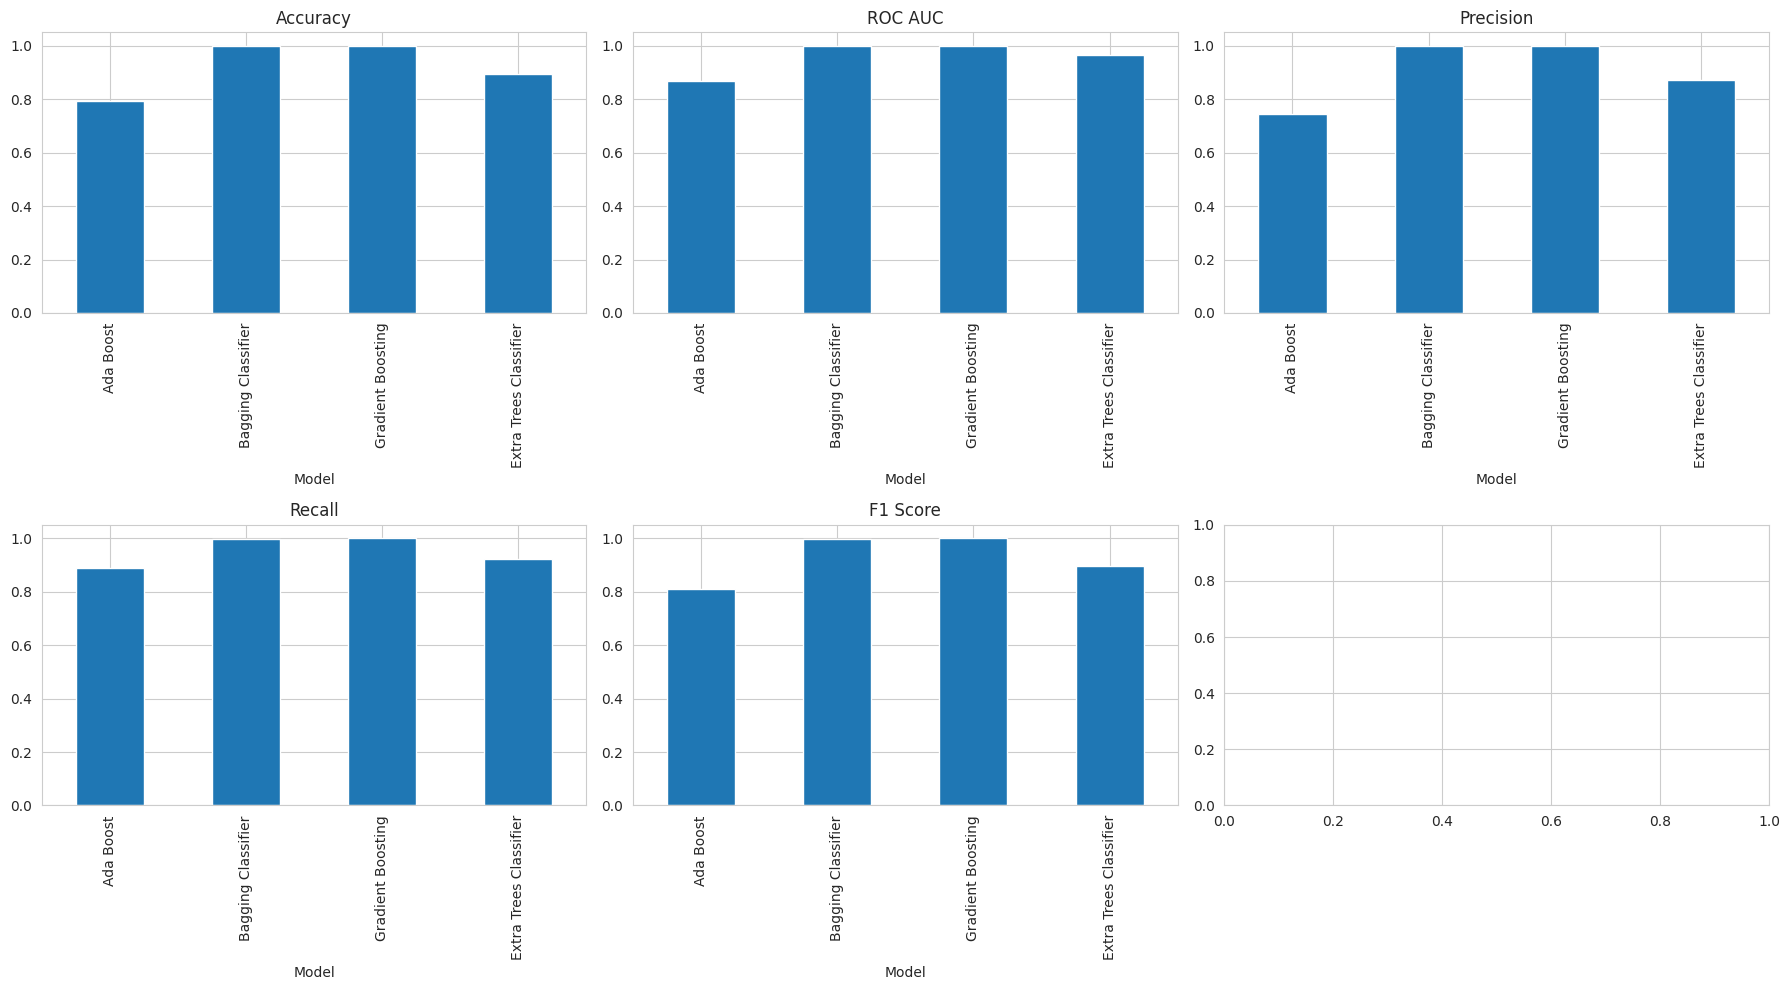

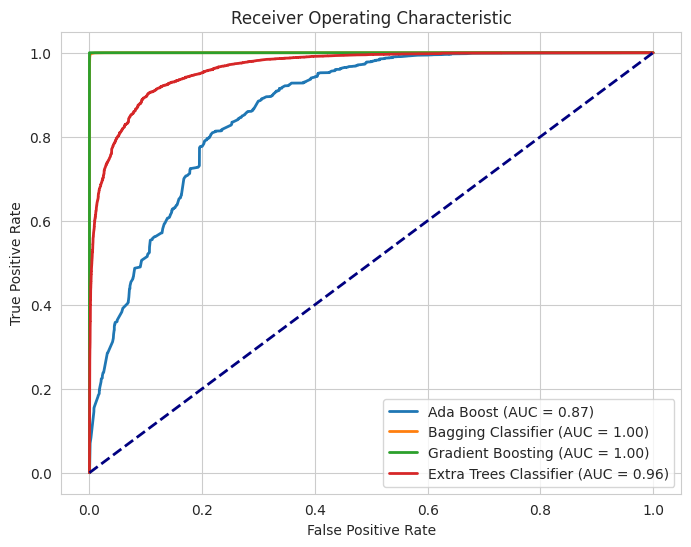

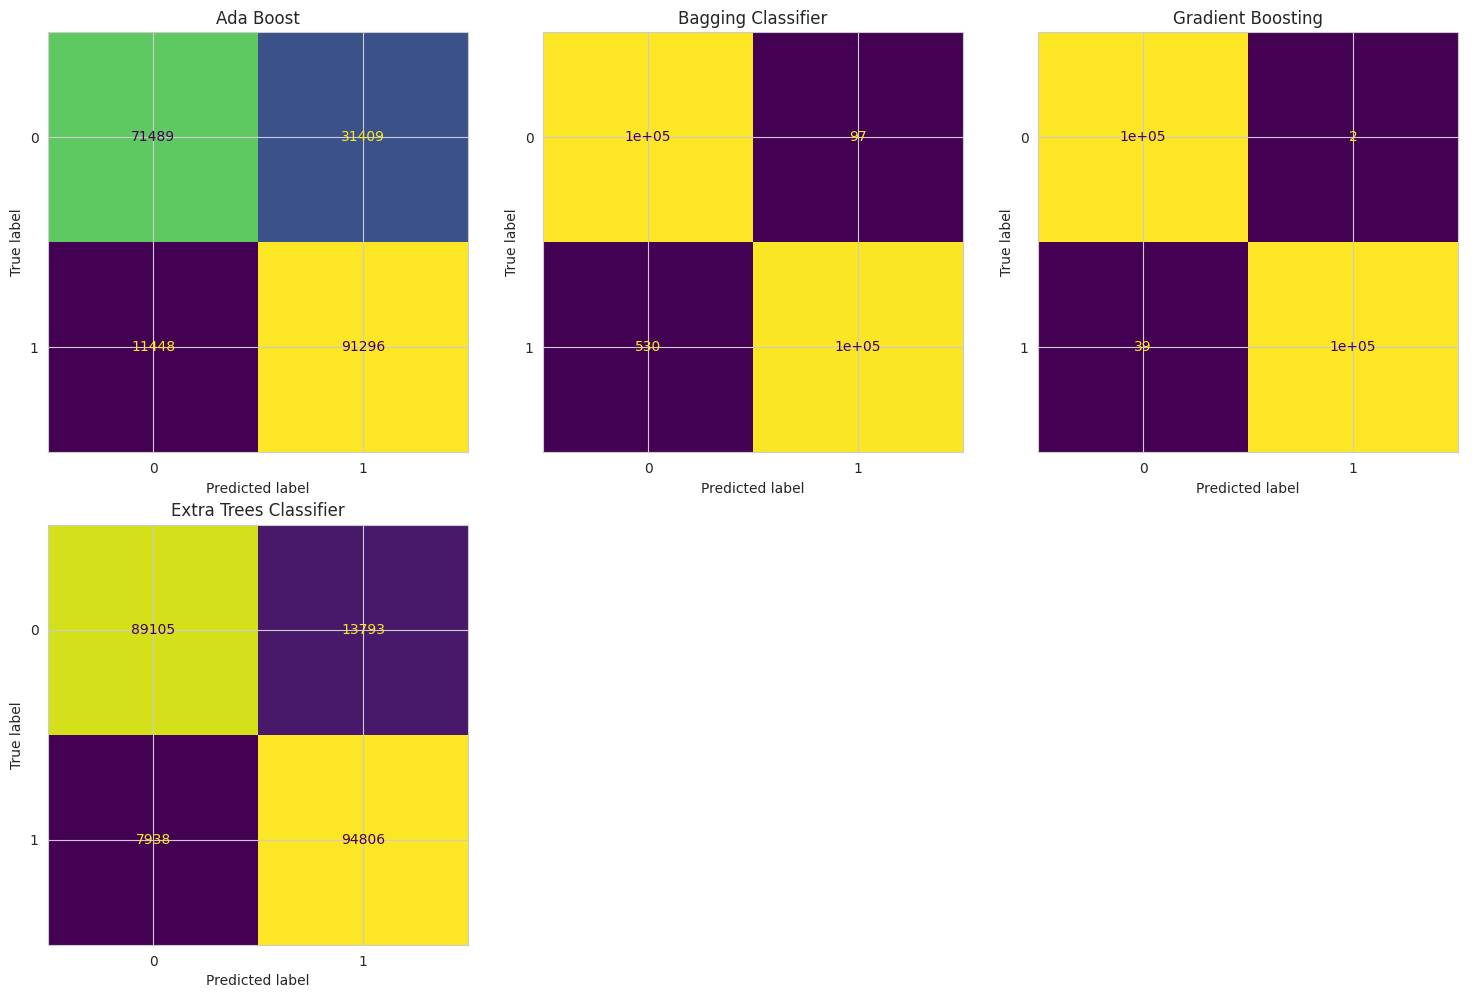

In [20]:
import pandas as pd
df_1=pd.read_csv("/kaggle/input/ember-adversarial-samples/adversarial_train_data.csv")
adv_x = df_1.drop(df_1.columns[-1], axis=1).values
adv_y=df_1[df_1.columns[-1]].values
X_train_final=np.vstack((X_train_final,adv_x))
y_train=np.hstack((y_train,adv_y))
print("Models performance on Adversarial examples: \n")
plot_results(get_results(models,adv_x,adv_y))
roc_auc_plot(models,adv_x,adv_y)
plot_confusion_matrix(models,adv_x,adv_y)

In [ ]:
print("Models performance on Adversarial examples: \n")
plot_results(get_results(models,adv_ex[0],adv_ex[1]))
roc_auc_plot(models,adv_ex[0],adv_ex[1])
plot_confusion_matrix(models,adv_ex[0],adv_ex[1])

## 5. Retrain Models for Robustness

In [21]:
for model_name, model in models.items():
    print("Now training :",model_name,"...")
    model.fit(X=X_train_final, y=y_train)

Now training : Ada Boost ...
Now training : Bagging Classifier ...
Now training : Gradient Boosting ...
Now training : Extra Trees Classifier ...


## 5.1 Evaluate Robust Models

Ada Boost Performance:
Accuracy: 0.7223
ROC AUC: 0.8285
Precision: 0.6671
Recall: 0.8874
F1 Score: 0.7616

Bagging Classifier Performance:
Accuracy: 0.9294
ROC AUC: 0.9774
Precision: 0.9165
Recall: 0.9448
F1 Score: 0.9305

Gradient Boosting Performance:
Accuracy: 0.936
ROC AUC: 0.9813
Precision: 0.9295
Recall: 0.9435
F1 Score: 0.9364

Extra Trees Classifier Performance:
Accuracy: 0.8603
ROC AUC: 0.9493
Precision: 0.8167
Recall: 0.9289
F1 Score: 0.8692



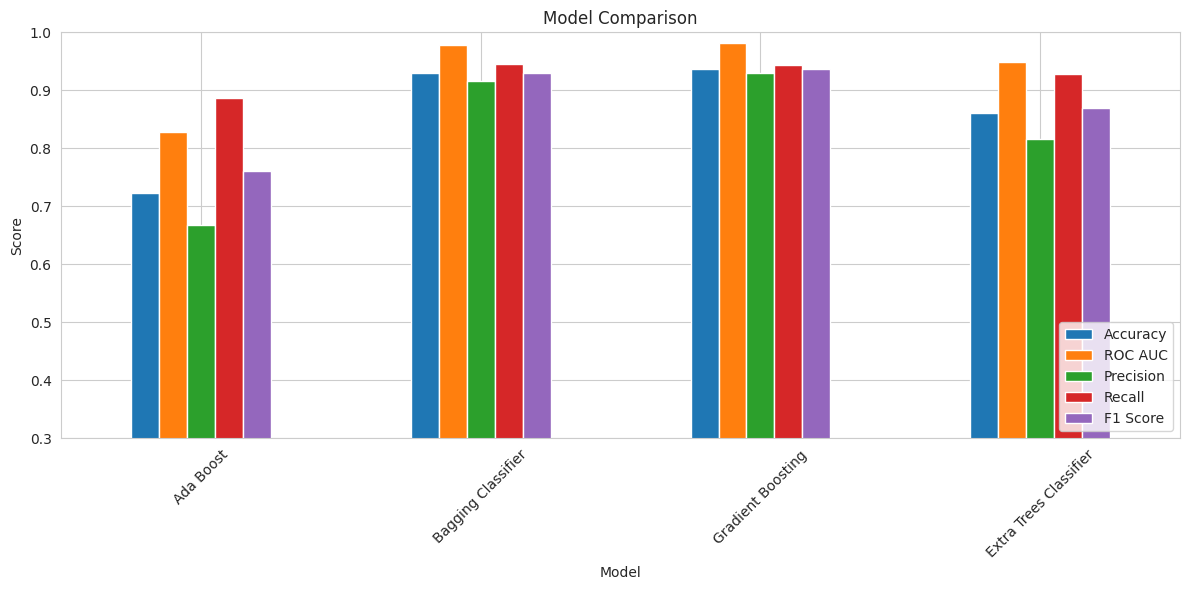

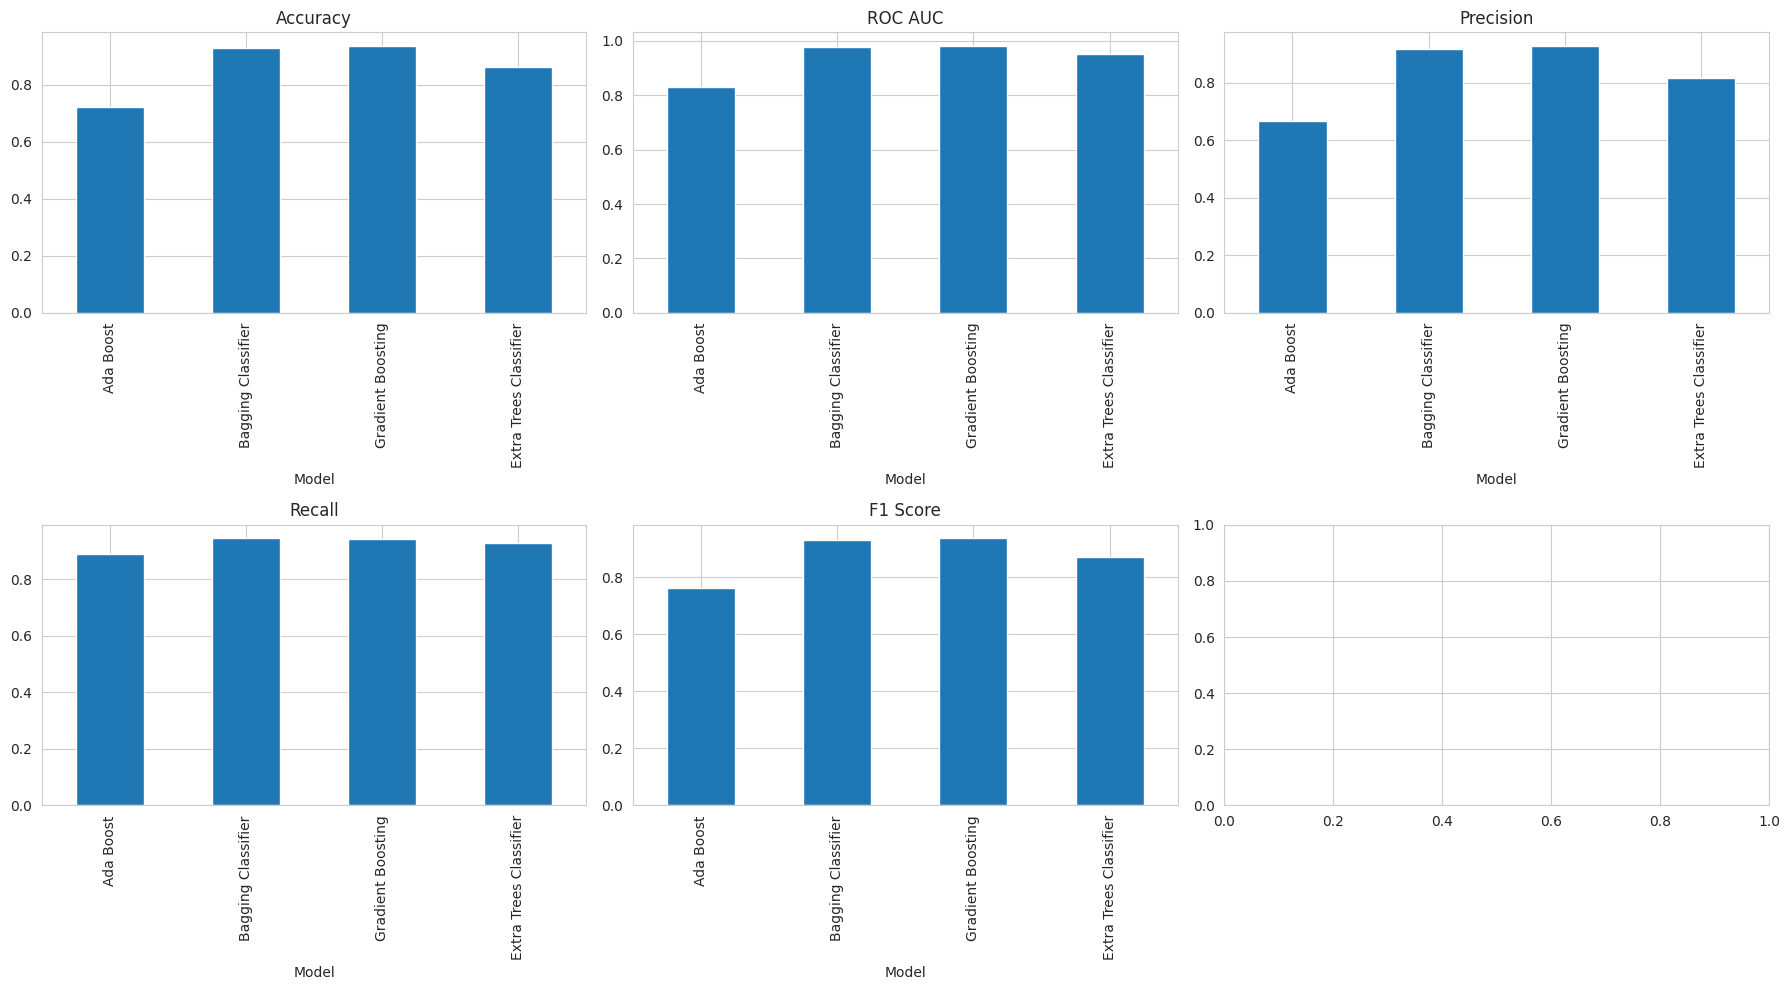

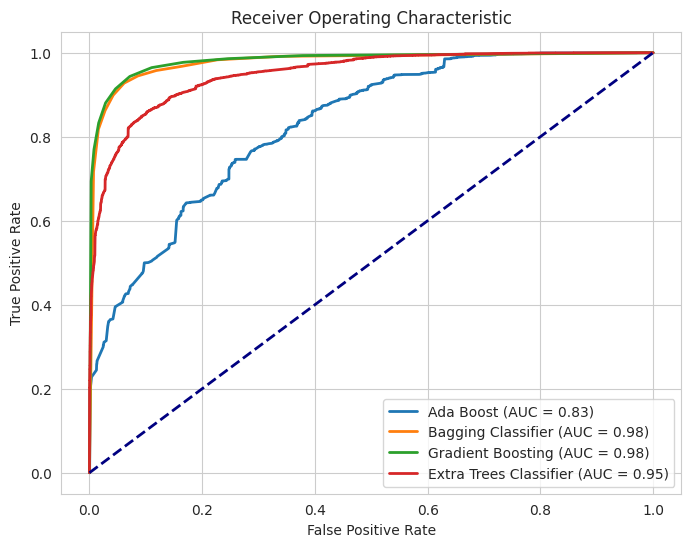

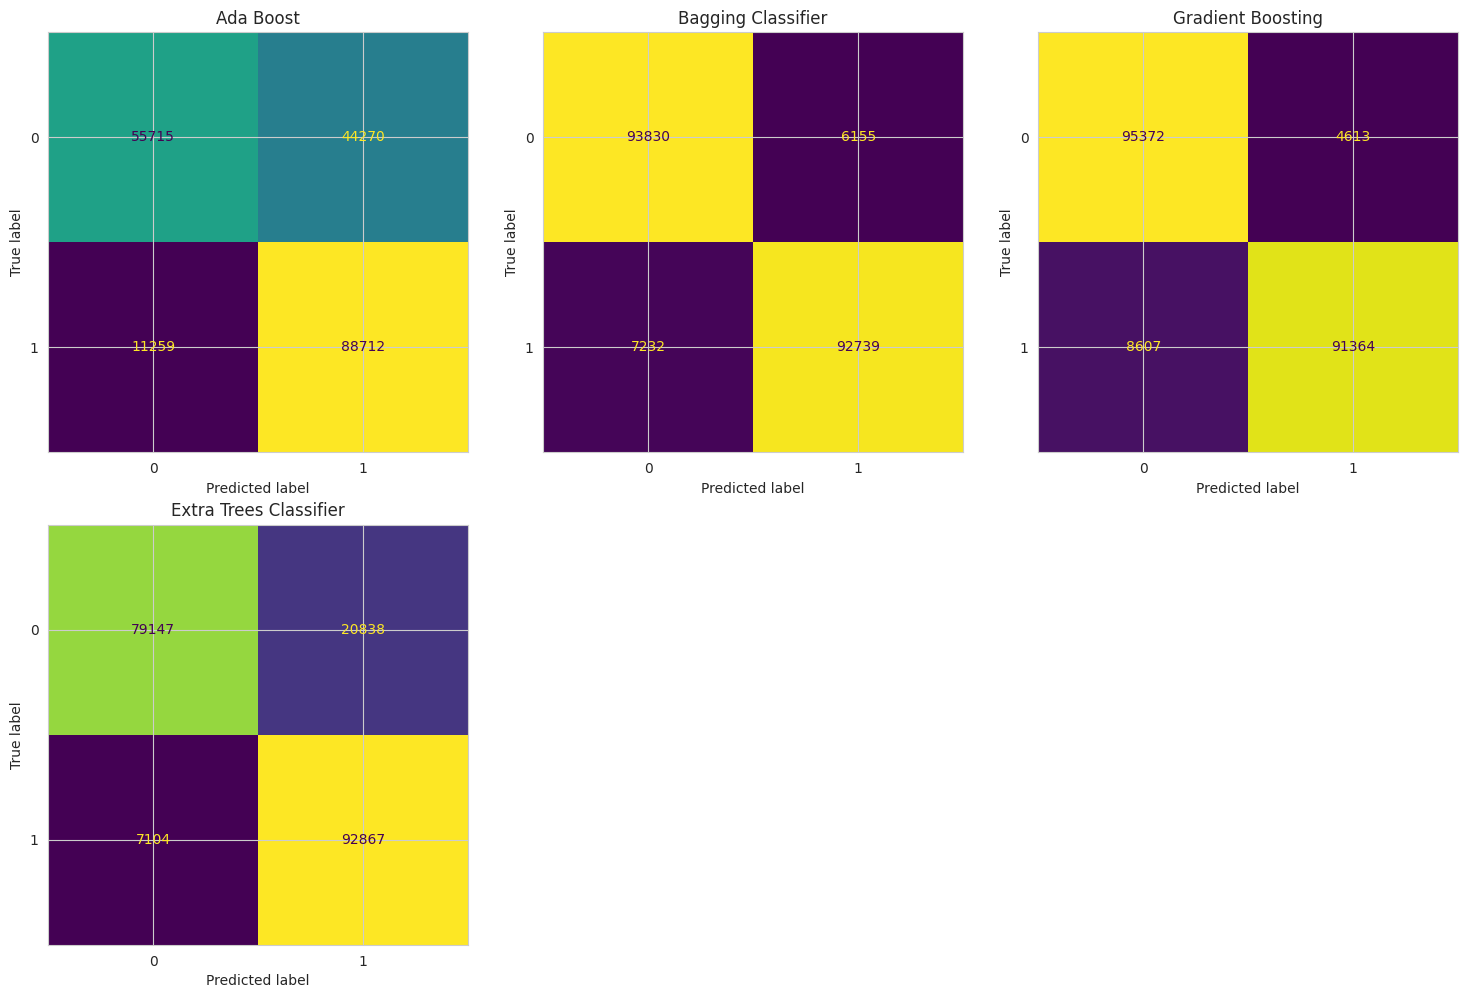

In [22]:
plot_results(get_results(models,X_test_final,y_test))
roc_auc_plot(models,X_test_final,y_test)
plot_confusion_matrix(models,X_test_final,y_test)

In [ ]:
import pandas as pd
df_1=pd.read_csv("/kaggle/input/ember-adversarial-samples/adversarial_train_data.csv")

In [ ]:
df_1.head()

In [ ]:
adv_x = df_1.drop(df_1.columns[-1], axis=1).values
adv_y=df_1[df_1.columns[-1]].values

Models performance on Adversarial examples: 

Ada Boost Performance:
Accuracy: 0.7913
ROC AUC: 0.8676
Precision: 0.7447
Recall: 0.886
F1 Score: 0.8093

Bagging Classifier Performance:
Accuracy: 1.0
ROC AUC: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Gradient Boosting Performance:
Accuracy: 1.0
ROC AUC: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Extra Trees Classifier Performance:
Accuracy: 0.8946
ROC AUC: 0.9643
Precision: 0.8741
Recall: 0.9217
F1 Score: 0.8973



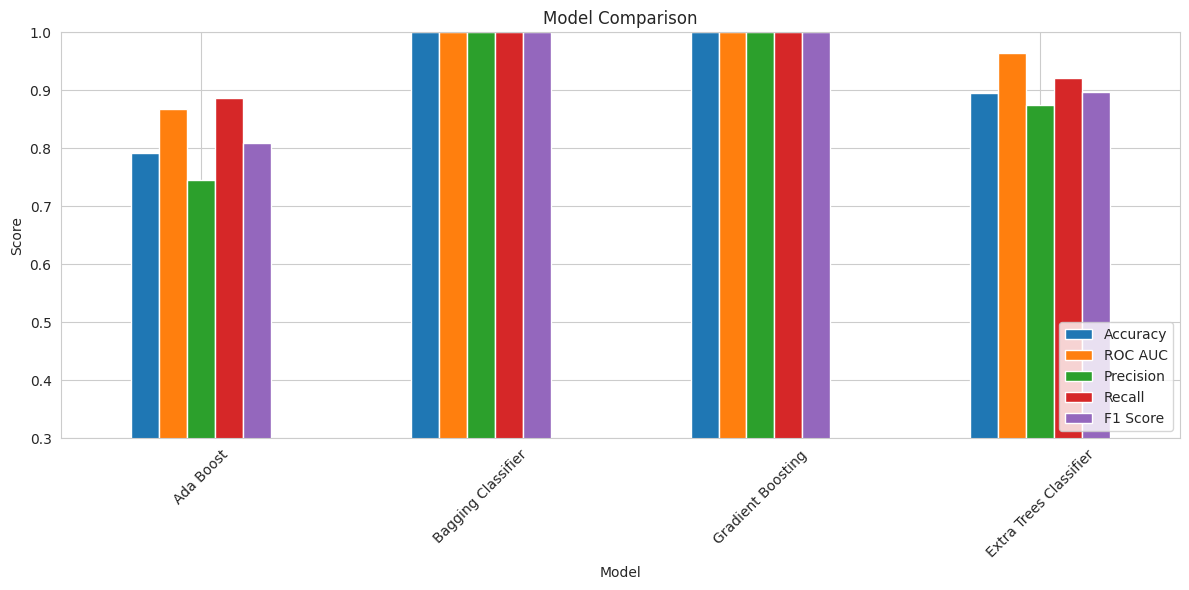

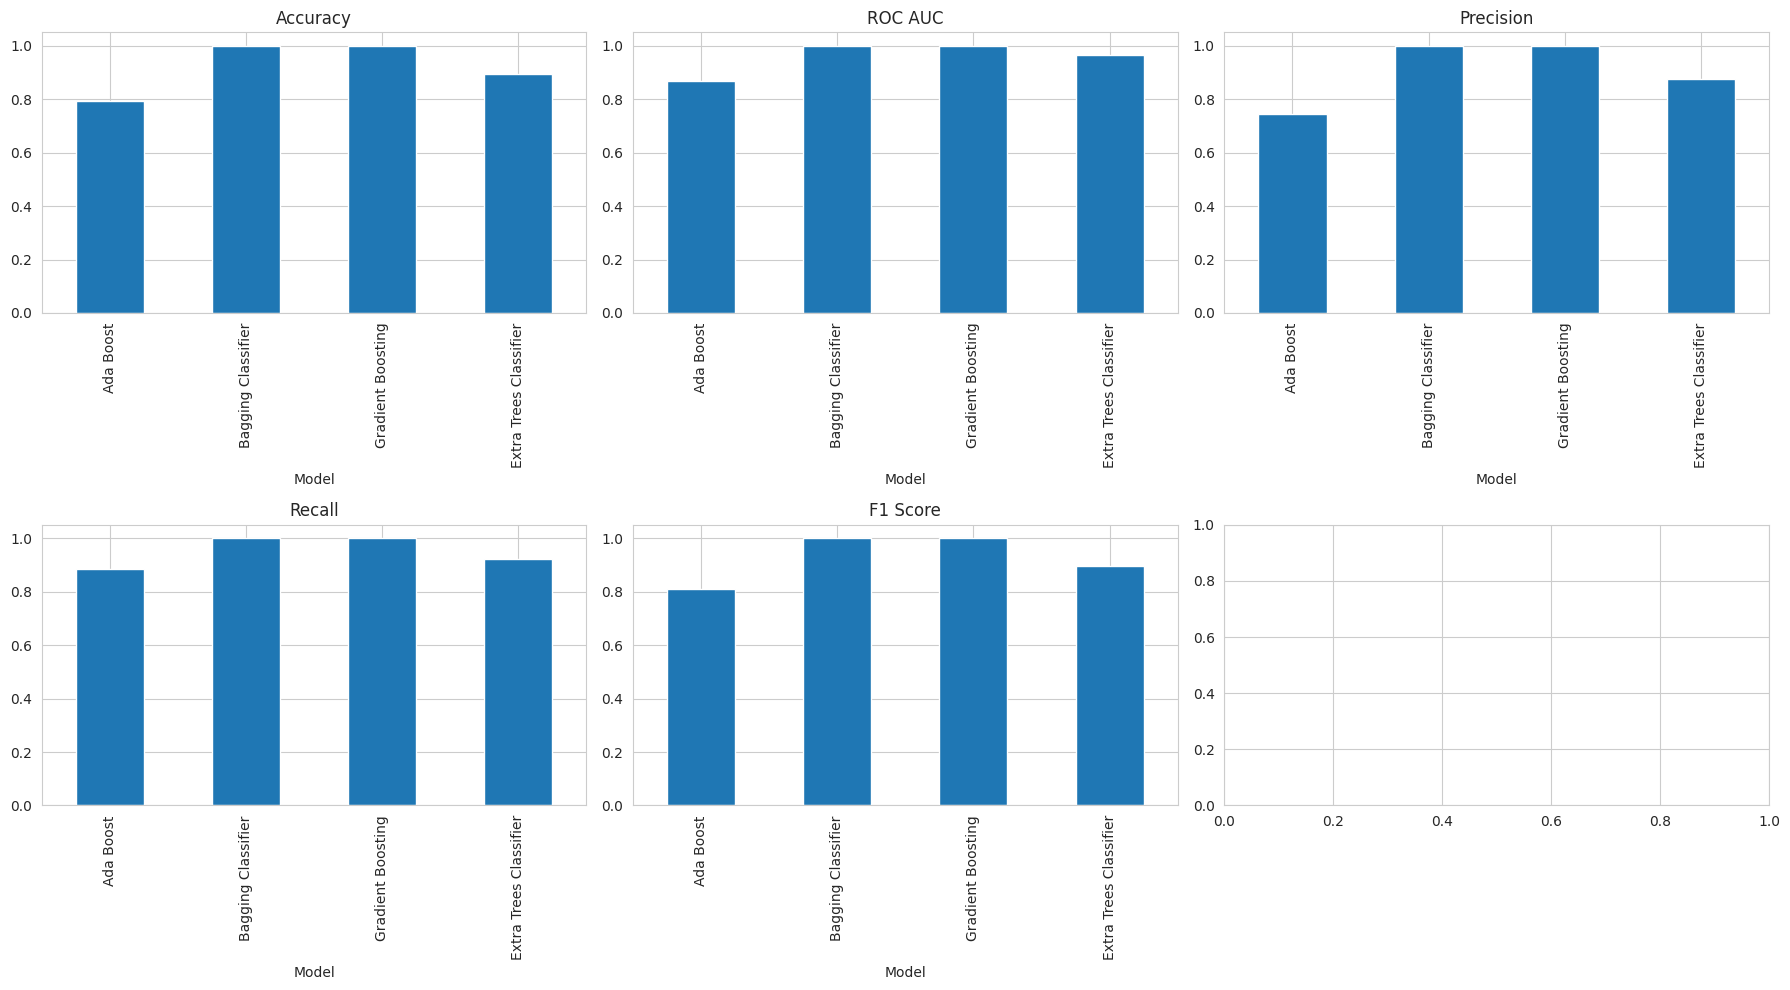

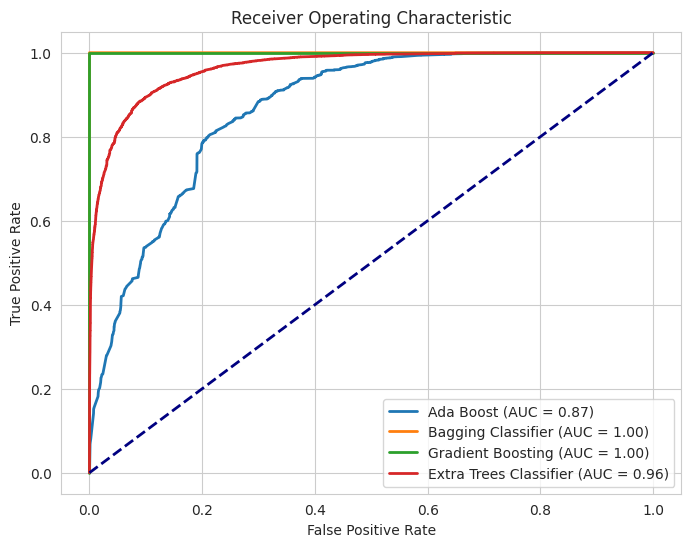

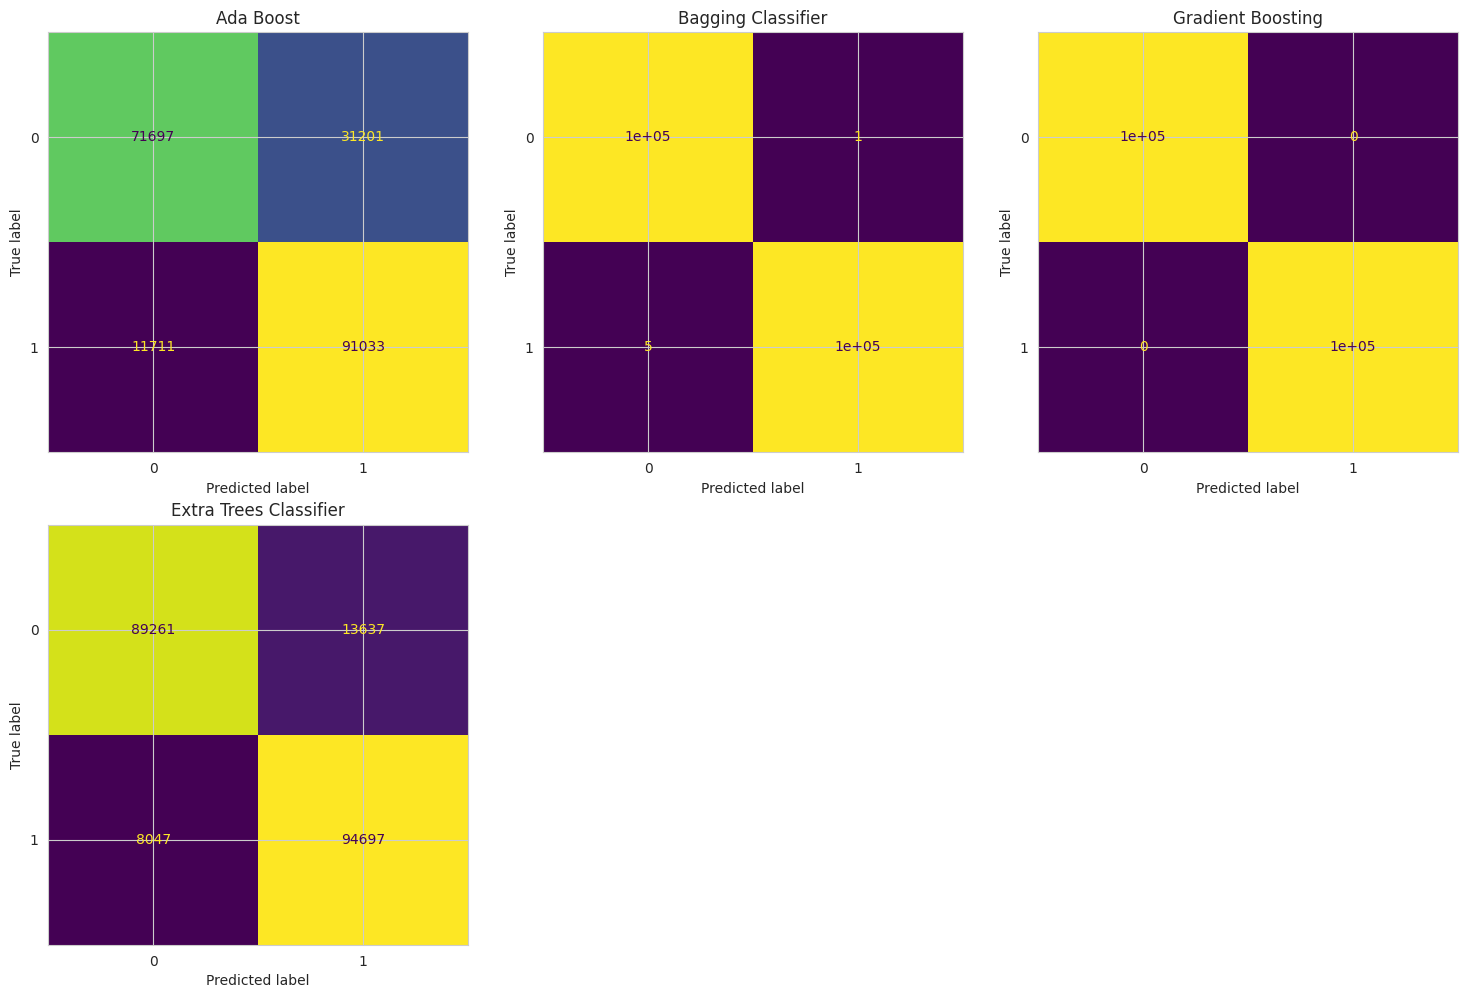

In [23]:
print("Models performance on Adversarial examples: \n")
plot_results(get_results(models,adv_x,adv_y))
roc_auc_plot(models,adv_x,adv_y)
plot_confusion_matrix(models,adv_x,adv_y)

In [ ]:
for model_name, model in models.items():
    x_train_adv = zoo_attack(model_name,model,X_train_final[:1000])
    score = model.score(X_train_final, y_train)
    print("Benign Training Score: %.4f" % score)
    score = model.score(x_train_adv, y_train[:1000])
    print("Adversarial Training Score: %.4f" % score)